In [3]:
from scipy.signal import lti
import numpy as np
from scipy.signal import lsim
import matplotlib.pyplot as plt


m = 0.5
c = 0.1

A = np.array([[0.0, 1.0], [0.0, -c/m]])
B = np.array([[0.0], [1/m]])
C = np.array([[1.0, 0.0]])
D = 0.0

def create_sys(m,c):
    A = np.array([[0.0, 1.0], [0.0, -c/m]])
    B = np.array([[0.0], [1/m]])
    C = np.array([[1.0, 0.0]])
    D = 0.0
    return lti(A, B, C, D)


system = lti(A, B, C, D)

In [4]:
t = np.linspace(0, 5, num=50)

u = np.ones_like(t) 


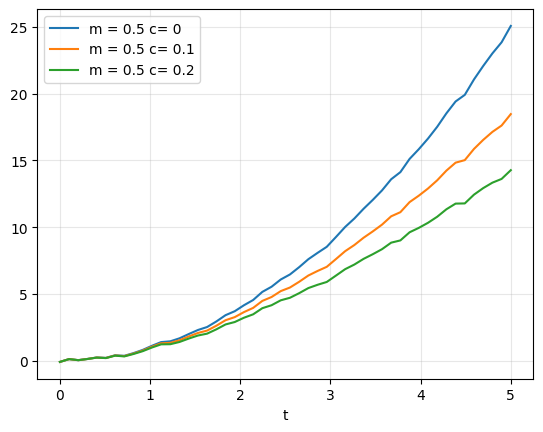

In [5]:
m,c = 0.5,0
tout, y, x = lsim(create_sys(m,c), u, t)
noise = np.random.randn(np.shape(y)[0]) *0.1
plt.plot(t, y+ noise, label= f'm = {m} c= {c}')
m,c = 0.5,0.1
tout, y, x = lsim(create_sys(m,c), u, t)
plt.plot(t, y+ noise, label= f'm = {m} c= {c}')
m,c = 0.5,0.2
tout, y, x = lsim(create_sys(m,c), u, t)
plt.plot(t, y+ noise, label= f'm = {m} c= {c}')
plt.grid(alpha=0.3)
plt.xlabel('t')
plt.legend()
plt.show()

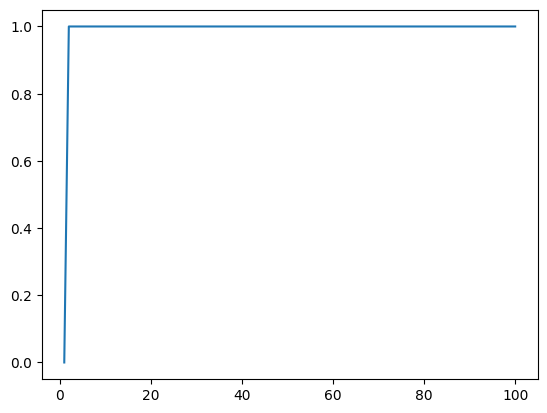

In [6]:
import numpy as np
from scipy.signal import lti
from scipy.optimize import curve_fit


def model(x, m, c):
    A = np.array([[0.0, 1.0], [0.0, -c/m]])
    B = np.array([[0.0], [1/m]]).T
    C = np.array([[1.0, 1.0]])
    D = 0.0
    # print(x)
    state = x[0]
    u = x[1]
    # print(state,u)
    
    x_next = A@state + (B*u).T
    
    # print(x_next)
    
    return  x_next

T = np.linspace(1,100,100,dtype=np.int32)
u = np.ones_like(T) 

x = np.array([[0],[0]])
length  = np.shape(T)[0]

states = np.zeros((length,2,1))
states[0] = x
m = 1
c = 0

for t in T-2:
   
    states[t+1] = model((states[t],u[t]),m,c)
    
    # states[int(t)] = x

# y = model(t, 10, 4)
# print(states)
plt.plot(T,states[:,0])

# par1 = curve_fit(create_sys(m,c).step(), t, u)


In [7]:
from scipy import signal
# Define a true system
m = 0.5
c = 0.1

A = np.array([[0.0, 1.0], [0.0, -c/m]])
B = np.array([[0.0], [1/m]])
C = np.array([[1.0, 0.0]])
D = 0.0

# Create a true LTI system
sys_true = signal.lti(A, B, C,D)

# Generate synthetic input data
t = np.linspace(0, 5, num=50)

u = np.random.randn(np.shape(t)[0]) 

# Simulate the true system
t_out, y_true, x_state = signal.lsim(sys_true, u, t)

y = y_true + np.random.randn(np.shape(y_true)[0])*0.01

# Now, let's try to estimate the system matrices A, B, C, and D from the input and output data
# Stack the input data to create the regressor matrix
U = np.vstack((u))

# Stack the output data to create the target matrix
Y = y.reshape(-1, 1)


print(u)


[ 1.15704107 -0.94484175  0.2388381  -1.47931139 -1.11334205 -1.6303932
  0.00994804 -0.87181132  1.09890159 -0.81242034  0.32061381 -1.36051875
  0.79366793  0.06969675  0.43979106 -0.85692635 -0.57961769 -1.64300006
  0.99477189 -0.24654775 -0.12108039  0.45839625 -0.83655374  0.94325729
 -0.27037319 -0.44911216 -0.13203947 -0.89241515 -0.82764066 -0.31759503
  0.12142842 -1.02414148  1.83503353 -1.47445652 -1.15821104 -0.4843289
  1.58082256  1.41834839  0.8871418  -0.12966432 -0.48558477  1.1516188
 -0.75478916  0.39796665  0.0138792   0.24380836  1.13452167 -0.64977715
 -0.44638504 -1.20864271]


In [8]:
import math
import torch
import gpytorch

class MyGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)


train_y = torch.tensor(np.diff(y))
train_x = torch.tensor(np.array([y[:-1], u[:-1]]).T)

# test_y = torch.tensor(np.diff(x)[test_samples])
test_states =  np.linspace(min(y),max(y))
test_inputs = np.ones_like(test_states)
test_x = torch.tensor(np.array([test_states,test_inputs]).T,device=torch.device('cpu'))
test_x = train_x

# train_x = ...; train_y = ...
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MyGP(train_x, train_y, likelihood)

# Transferring the model to a CUDA enabled GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(device)
# model = model.to(device)

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# test_x = ...;
model(test_x)  # Returns the GP latent function at test_x
observed_pred = likelihood(model(test_x))  # Returns the (approximate) predictive posterior distribution at test_x

c:\Users\RushiS\anaconda3\lib\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [9]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.5)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    model(test_x)  # Returns the GP latent function at test_x
    observed_pred = likelihood(model(test_x))  # Returns the (approximate) predictive posterior distribution at test_x
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item(),
        
    ))
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()
    optimizer.step()

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

fpreds = model(test_x)  # Returns the GP latent function at test_x
observed_pred = likelihood(model(test_x))  # Returns the (approximate) predictive posterior distribution at test_x

Iter 1/100 - Loss: 0.956   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 0.725   lengthscale: 0.974   noise: 0.474
Iter 3/100 - Loss: 0.487   lengthscale: 1.309   noise: 0.313
Iter 4/100 - Loss: 0.244   lengthscale: 1.682   noise: 0.201
Iter 5/100 - Loss: -0.001   lengthscale: 2.074   noise: 0.126
Iter 6/100 - Loss: -0.248   lengthscale: 2.468   noise: 0.078
Iter 7/100 - Loss: -0.496   lengthscale: 2.855   noise: 0.048
Iter 8/100 - Loss: -0.741   lengthscale: 3.228   noise: 0.029
Iter 9/100 - Loss: -0.980   lengthscale: 3.581   noise: 0.018
Iter 10/100 - Loss: -1.210   lengthscale: 3.911   noise: 0.011
Iter 11/100 - Loss: -1.422   lengthscale: 4.214   noise: 0.006
Iter 12/100 - Loss: -1.607   lengthscale: 4.485   noise: 0.004
Iter 13/100 - Loss: -1.749   lengthscale: 4.713   noise: 0.002
Iter 14/100 - Loss: -1.832   lengthscale: 4.885   noise: 0.002
Iter 15/100 - Loss: -1.847   lengthscale: 4.978   noise: 0.001
Iter 16/100 - Loss: -1.813   lengthscale: 4.961   noise: 0.001
Iter 

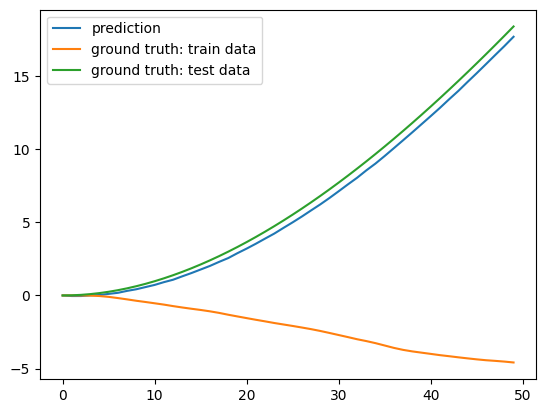

In [10]:
# Simulate the true system
t_out, y_test, x_state = signal.lsim(sys_true, test_inputs, t)
plt.plot(np.hstack((0, y_test[0:-1] + (observed_pred.mean.detach().numpy()))),label="prediction")
plt.plot(y_true,label="ground truth: train data")
plt.plot(y_test,label="ground truth: test data")
plt.legend()

In [17]:
state_dist_mean = y_test[0:-1] + fpreds.mean.detach().numpy()
print(state_dist_mean)
state_dist_var = fpreds.covariance_matrix.detach().numpy()
print((state_dist_var))

[-2.90160026e-02  1.16406551e-02  1.92140072e-02  6.79311916e-02
  1.37345963e-01  2.48330650e-01  3.39957727e-01  4.81425208e-01
  6.02863728e-01  7.91990532e-01  9.71973096e-01  1.17740977e+00
  1.39089836e+00  1.61106417e+00  1.84912936e+00  2.11434353e+00
  2.38409793e+00  2.67894651e+00  3.01007421e+00  3.31655783e+00
  3.66078600e+00  3.98963976e+00  4.35280856e+00  4.73043892e+00
  5.11973303e+00  5.53692160e+00  5.93415250e+00  6.35401729e+00
  6.79035635e+00  7.26810284e+00  7.71225618e+00  8.19122778e+00
  8.66706654e+00  9.14820399e+00  9.65435161e+00  1.01882881e+01
  1.06991306e+01  1.12237445e+01  1.17686201e+01  1.23301533e+01
  1.29114442e+01  1.34704265e+01  1.40413658e+01  1.46419847e+01
  1.52278876e+01  1.58537998e+01  1.64834691e+01  1.70796763e+01
  1.77050987e+01]
[[ 1.82282187e-04 -4.88802296e-08  1.06943589e-05 ...  4.13327689e-07
   3.02431307e-05  1.52201131e-04]
 [-4.88802296e-08  1.90128004e-04  6.50417166e-06 ...  2.11706043e-04
   1.11684102e-05 -7.564738

# RBF Controller Psuedo GPR

In [15]:
u_bang_bang = np.genfromtxt('./bang_bang_controller.csv', delimiter=',')
x_bang_bang = np.genfromtxt('./bang_bang_states.csv', delimiter=',')

x_bang_bang = x_bang_bang[:,:-1].T
u_bang_bang =u_bang_bang[:,None]
num_basis = len(u_bang_bang)

print(np.shape(x_bang_bang))
print(np.shape(u_bang_bang))
print(num_basis)

# np.random.randn(num_basis_functions, state_dim),
# 0.1*np.random.randn(num_basis_functions, control_dim)

x_values = x_bang_bang
y_values = u_bang_bang

(21, 2)
(21, 1)
21


In [23]:
import math
import torch
import gpytorch

class MyGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2,
                    
                    batch_shape=torch.Size([train_y.shape[1]])))

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)


# train_x = ...; train_y = ...
train_x  = torch.from_numpy(x_values).cuda()
train_y = torch.from_numpy(y_values).cuda()
likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=torch.Size([train_y.shape[0]]))
model = MyGP(train_x, train_y, likelihood)

# Transferring the model to a CUDA enabled GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(device)
# model = model.to(device)

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

test_x = torch.tensor([[-1],[0]]).cuda()
model(test_x)  # Returns the GP latent function at test_x
observed_pred = likelihood(model(test_x))  # Returns the (approximate) predictive posterior distribution at test_x

RuntimeError: Flattening the training labels failed. The most common cause of this error is that the shapes of the prior mean and the training labels are mismatched. The shape of the train targets is torch.Size([21, 1]), while the reported shape of the mean is torch.Size([21]).

In [18]:
import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np
import random
from os import path

class DoubIntEnv(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 24
    }

    def __init__(self,m=1,c=0):

        self.m = m
        self.c = c

        self.dt = 0.1
        self.map_limit = 2
        self.dense_parameter = 20
        mapq, mapdq = np.meshgrid(np.linspace(-self.map_limit, self.map_limit, self.dense_parameter)
                                 , np.linspace(-self.map_limit, self.map_limit, self.dense_parameter))

        self.observation_space_low = np.array([-self.map_limit, -self.map_limit])
        self.observation_space_high = np.array([self.map_limit, self.map_limit])
        self.seed()
        self.viewer = None
        self.state = None
        self.ep_limit = 1000
        self.umin = -1.
        self.umax = 1.
        self.steps_beyond_done = None
        self.action_space = spaces.Box(low=np.array([self.umin]),
                               high=np.array([self.umax]),
                               dtype=np.float32)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_discrete(self, s):
        dis_state = (((s - self.observation_space_low)
                     /(self.observation_space_high - self.observation_space_low))
                    *self.dense_parameter)

        return dis_state.astype(np.int)

    def step(self, act):
        
        
        
        q, q_dot = self.state
        dt = self.dt
        u = act
        q = q + dt*q_dot
        q_dot = q_dot*(-self.c/self.m) + (1/self.m)*dt*u
        self.last_u = u
        
        self.state = (np.array([q, q_dot]))

        done = False

        # if (abs(q) <= 0.1) and (abs(q_dot) <= 0.1):
        #     cost = 10.0
        #     done = True
        
        # else:
        #     cost = -abs(q) - abs(q_dot)
        #     self.ep_count +=1
        cost = -abs(q) - abs(q_dot)
        self.ep_count +=1

        if self.ep_count >= self.ep_limit:
            done = True

        if abs(q) >= (self.map_limit):
            cost = -abs(q) - abs(q_dot)
            done = True

        return np.array(self.state), cost, done, {}

    def reset(self):

        self.steps_beyond_done = None
        states = [np.array([self.map_limit - 0.1, 0])
                  , np.array([-self.map_limit + 0.1, 0])
                  ]
        # self.state = (random.choice(states))
        self.state = (np.array([0,0]))
        self.ep_count = 0
        return np.array(self.state)
        

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        world_width = self.map_limit * 2
        scale = screen_width/world_width
        carty = 200  # TOP OF CART
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
            l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
            axleoffset = cartheight / 4.0
            cart = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.carttrans = rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)

            self.track = rendering.Line((0, carty), (screen_width, carty))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

            self.goal = rendering.Line((screen_width/2, 0), (screen_width, screen_height))
            self.goal.set_color(0, 0, 255)

        if self.state is None:
            return None

        x = self.state
        cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)

        return self.viewer.render(return_rgb_array=mode == 'rgb_array')

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None



In [19]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [20]:
from IPython import display as disp
def render(env, policy=None):
    """Graphically render an episode using the given policy

    :param env:  Gym environment
    :param policy:  function which maps state to action.  If None, the random
                    policy is used.
    """

    if policy is None:

        def policy(state):
            return env.action_space.sample()

    state = env.reset()
    env.render()
    # img = plt.imshow(env.render())

    while True and env.ep_count<env.ep_limit:
        action = policy(state)
        state, _, done,_ = env.step(action)
        env.render()
        # img.set_data(env.render()) # just update the data
        # disp.display(plt.gcf())
        # disp.clear_output(wait=True)

        if done:
            break
            
    env.close()

In [21]:
env = DoubIntEnv(m=1,c=0.1)
render(env)
env.close()

/home/rushiwsl/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/rushiwsl/.local/lib/python3.6/site-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [22]:
import gym
import time
from IPython import display as disp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


env = DoubIntEnv(m=1,c=0)
# env = gym.make('CartPole-v1',render_mode='rgb_array')
env.reset()
# img = plt.imshow(env.render() # only call this once

env.render()

done = False
costs = []
ctr = 0
while not done:
    
    # action = env.action_space.sample()
    if ctr<10:
        action = np.array([10],dtype=np.float32)
    else:
        action = np.array([0],dtype=np.float32)
    ctr+=1
    next_state, cost, done, _ = env.step(action)
    env.render()
    # print(next_state)
    costs.append(cost)

env.close()
print(sum(costs))

/home/rushiwsl/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/rushiwsl/.local/lib/python3.6/site-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[-1004.5]
